The unsupervised learning code of motorcycle crash analysis

In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# Load unclean file
file = 'MotorBike_Accident_analysisUnclean.xlsx'
data = pd.read_excel(file)

In [5]:
# Clean names to keep only the English part of the column names
def clean_column(col):
	return col.split('(')[0].strip()

data.columns = [clean_column(col) for col in data.columns]

# Remove rest of strange languege from the rows
import re
def remove_parentheses(text):
	if isinstance(text, str):
		return re.sub(r'\s*\([^)]*\)', '', text).strip()
	return text

for col_idx, col in enumerate(data.columns):
	if col_idx != 5:  
		data[col] = data[col].apply(remove_parentheses)

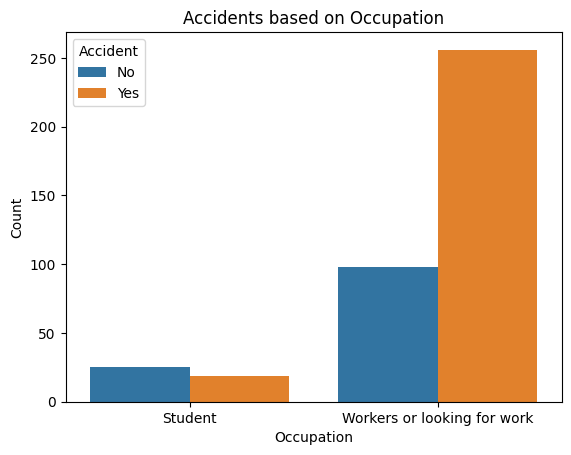

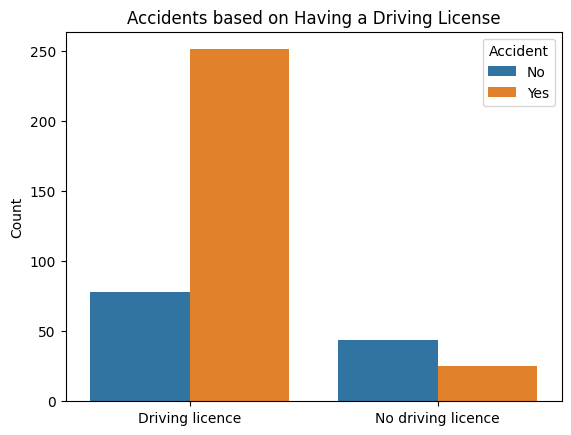

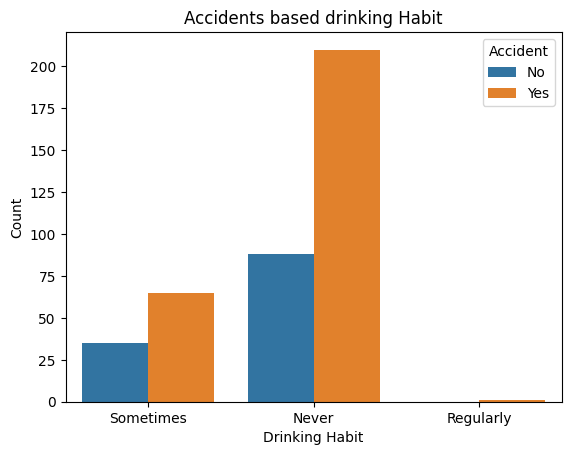

In [6]:
# Simple visualisation of data Based on the before imputed data

# Accidents based on Occupation
sns.countplot(x='6. Occupation', hue='15. Have you faced any road traffic accident over the last one year period?', data=data)
plt.title('Accidents based on Occupation')
plt.legend(title='Accident', labels=['No', 'Yes'])
plt.ylabel('Count')
plt.xlabel('Occupation')
plt.xticks(ticks=[0, 1], labels=['Student', 'Workers or looking for work'])
plt.show()

# Accidents based on having a driving license
sns.countplot(x='11. Do you have riding licence?', hue='15. Have you faced any road traffic accident over the last one year period?', data=data)
plt.title('Accidents based on Having a Driving License')
plt.legend(title='Accident', labels=['No', 'Yes'])
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(ticks=[0, 1], labels=['Driving licence', 'No driving licence'])
plt.show()

# Accidents based on Drinking Habit
sns.countplot(x='20. Drinking status', hue='15. Have you faced any road traffic accident over the last one year period?', data=data)
plt.title('Accidents based drinking Habit')
plt.legend(title='Accident', labels=['No', 'Yes'])
plt.ylabel('Count')
plt.xlabel('Drinking Habit')
plt.show()

In [33]:
# Impute missing values

# Encode all categorical variables to numbers
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded_data = encoder.fit_transform(data)

# Impute missing values using RandomForestClassifier
imputer = IterativeImputer(estimator=RandomForestClassifier(), random_state=0)
imputed_encoded = imputer.fit_transform(encoded_data)

# Decode the data back to categories
imputed_data = pd.DataFrame(encoder.inverse_transform(imputed_encoded), columns=data.columns)

# Display rows to see if it worked
print(imputed_data.head())

  1. Gender 2. Living place 3. Age 4. Riding experience 5. Marital status  \
0      Male           Rural  20-29                  1-5         Unmarried   
1      Male           Urban  30-39                  1-5           Married   
2      Male           Rural  20-29                  1-5         Unmarried   
3      Male           Rural  30-39                  1-5           Married   
4      Male           Rural  20-29                11-15         Unmarried   

                                       6. Occupation 7. Education level  \
0                                            Student  Above high school   
1  Others (including workers, office staff, gradu...  Above high school   
2                                            Student  Above high school   
3  Others (including workers, office staff, gradu...  Above high school   
4                                            Student  Above high school   

  8. Employment status 9. Motorcycle's brand name  \
0            Part-time           

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


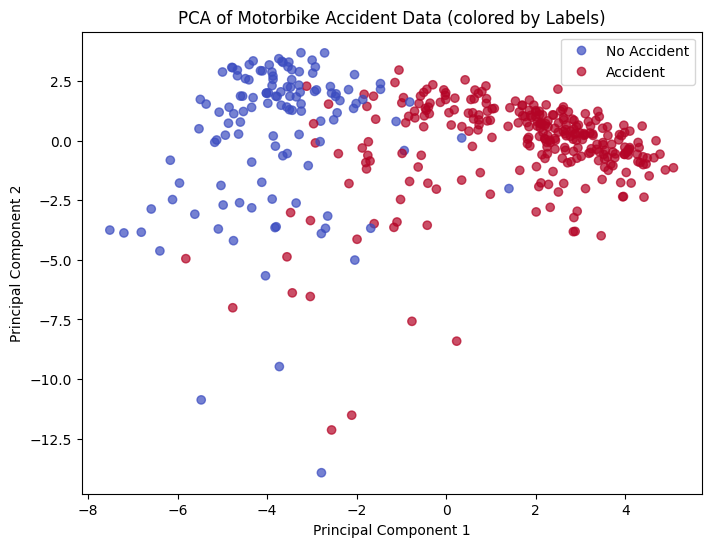

In [ ]:
# Doing PCA

# Standardize the features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # to keep all categorical info
scaler = StandardScaler()
features_encoded = encoder.fit_transform(imputed_data)
scaled_features = scaler.fit_transform(features_encoded)

# Get labels
accident = imputed_data['15. Have you faced any road traffic accident over the last one year period?']
accident_num = accident.map({'No': 0, 'Yes': 1})

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Visualize
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_result[:,0], pca_result[:,1], c=accident_num, cmap='coolwarm', alpha=0.7) # color by accident labels
plt.legend(handles=scatter.legend_elements()[0], labels=['No Accident', 'Accident'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Motorbike Accident Data (colored by Labels)')
plt.show()

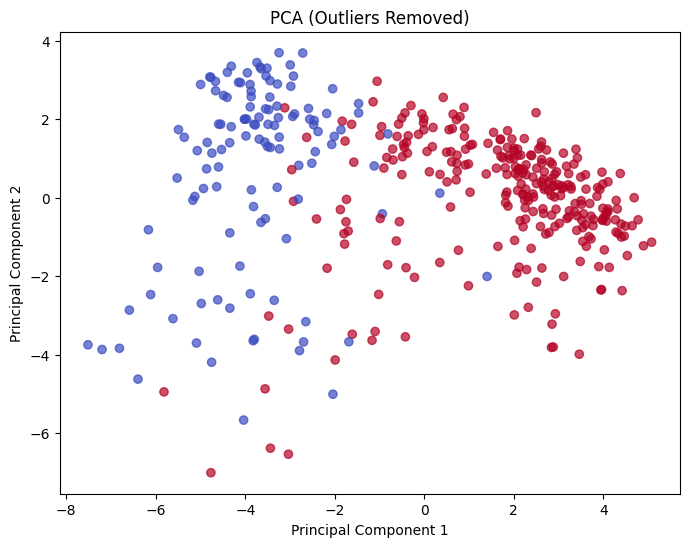

In [35]:
# Outlier removal

# Compute z-scores for both PC1 and PC2
z_scores = np.abs(stats.zscore(pca_result))

# Define a threshold (trail and error to find best value)
threshold = 3

# Keep samples within the threshold
mask = (z_scores < threshold).all(axis=1)

# Filter your data
pca_result_filtered = pca_result[mask]
accident_num_filtered = accident_num[mask]
scaled_features_filtered = scaled_features[mask]

# Visualize
plt.figure(figsize=(8,6))
plt.scatter(pca_result_filtered[:,0], pca_result_filtered[:,1],
            c=accident_num_filtered, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA (Outliers Removed)')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


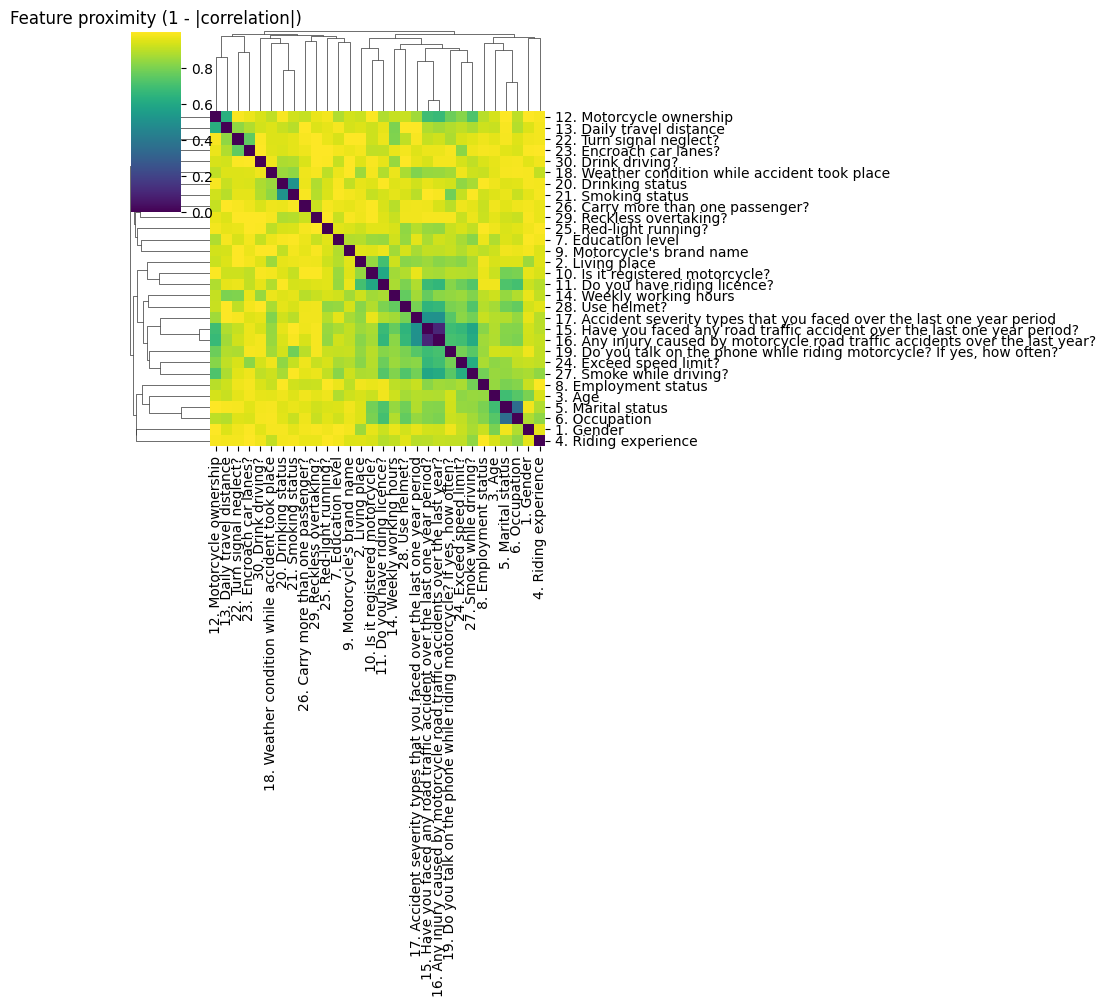

In [37]:
# Proximity matrix

# outlier removal from PCA
z_scores = np.abs(stats.zscore(pca_result))
threshold = 3
mask = (z_scores < threshold).all(axis=1)
imputed_data_filtered = imputed_data[mask]

imputed_enc = encoder.fit_transform(imputed_data_filtered)
imputed_enc_df = pd.DataFrame(imputed_enc, columns=imputed_data_filtered.columns)

# Compute correlation matrix between columns
corr_matrix = imputed_enc_df.corr()

# Convert to a proximity-like matrix (1 - |correlation|)
proximity_features = 1 - abs(corr_matrix)

sns.clustermap(proximity_features, cmap='viridis')
plt.title('Feature proximity (1 - |correlation|)')
plt.show()